In [1]:
!python -V

Python 3.12.1


In [2]:
import mlflow
import os
import boto3
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

In [3]:
os.environ["AWS_PROFILE"] = "user1" # fill in with your AWS profile. More info: https://docs.aws.amazon.com/sdk-for-java/latest/developer-guide/setup.html#setup-credentials

In [4]:
# Load .env
load_dotenv()

# S3 client
s3 = boto3.client("s3")
bucket = os.getenv("S3_BUCKET_NAME")

print(f"Using bucket: {bucket}")
print(s3.list_objects(Bucket=bucket))

Using bucket: taxi-duration-artifacts
{'ResponseMetadata': {'RequestId': 'SM9SJX6YF2Z6DA1W', 'HostId': 'rbMJ+75YrFYPK13km65bQLvBnNVaAsEg8qMLSsR5PWyy3OKHzZIZmKpsjwgRyQC43xmpf5yx7fVUE/JCc0jVWx4ijEm0CVXt6ffxaviYwWs=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'rbMJ+75YrFYPK13km65bQLvBnNVaAsEg8qMLSsR5PWyy3OKHzZIZmKpsjwgRyQC43xmpf5yx7fVUE/JCc0jVWx4ijEm0CVXt6ffxaviYwWs=', 'x-amz-request-id': 'SM9SJX6YF2Z6DA1W', 'date': 'Sat, 04 Oct 2025 05:16:27 GMT', 'x-amz-bucket-region': 'us-east-2', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'IsTruncated': False, 'Marker': '', 'Name': 'taxi-duration-artifacts', 'Prefix': '', 'MaxKeys': 1000, 'EncodingType': 'url'}


In [5]:
TRACKING_SERVER_HOST = os.getenv("EC2_PUBLIC_DNS") # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [6]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000'


In [7]:
mlflow.search_experiments() # list_experiments API has been removed, you can use search_experiments instead.()

[<Experiment: artifact_location='s3://taxi-duration-artifacts/2', creation_time=1759554508528, experiment_id='2', last_update_time=1759554508528, lifecycle_stage='active', name='exp_2_linear_models', tags={}>,
 <Experiment: artifact_location='s3://taxi-duration-artifacts/1', creation_time=1759269423243, experiment_id='1', last_update_time=1759269423243, lifecycle_stage='active', name='exp_1_linear_models', tags={}>,
 <Experiment: artifact_location='s3://taxi-duration-artifacts/0', creation_time=1759266677185, experiment_id='0', last_update_time=1759266677185, lifecycle_stage='active', name='Default', tags={}>]

### link to user guide

https://www.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf

### link to data dictionary

https://data.cityofnewyork.us/api/views/hvrh-b6nb/files/65544d38-ab44-4187-a789-5701b114a754?download=true&filename=data_dictionary_trip_records_green.pdf

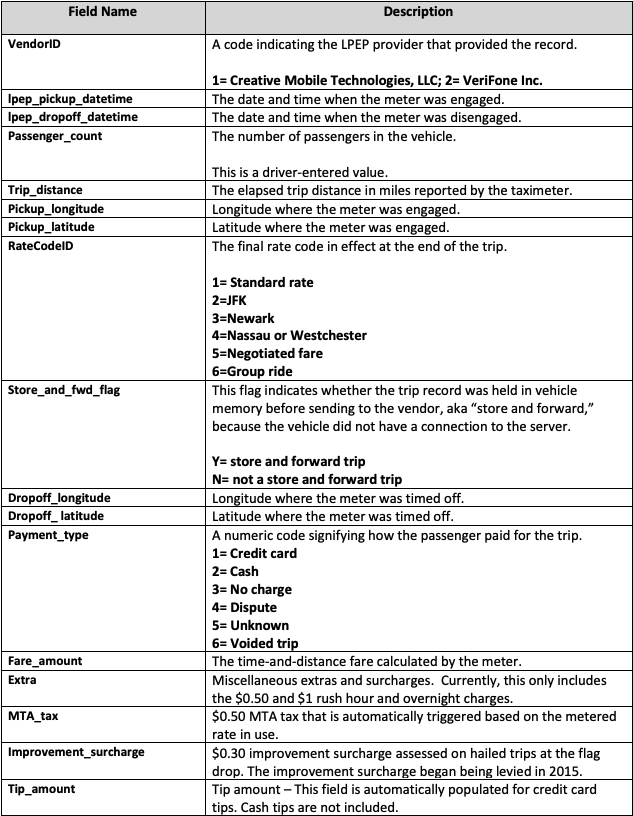
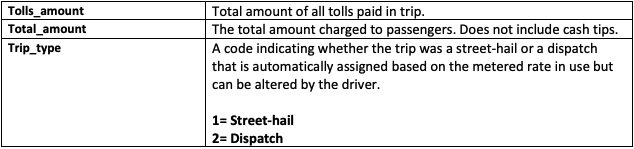


## Preprocessing

In [8]:
def read2df(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    df['PU_DO'] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str) #could backfire as it could create combonatorial explosion
    df['pu_hour'] = df['lpep_pickup_datetime'].dt.hour #isolate the hour of the day of pickup
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime #create response variable
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) 

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID', 'PU_DO']
    df[categorical] = df[categorical].astype(str) # DictVectorizer inputs dict of strs and outputs numpy array
    
    return df

In [9]:
# now training set will be the month before the validation set
df_train = read2df('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet')
df_val = read2df('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-03.parquet')

In [10]:
len(df_train), len(df_val)

(44218, 48336)

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance','pu_hour','tolls_amount']

In [17]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = df_train['duration'].values

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val['duration'].values


# this is just for mlflow to stop shouting at me. It just a toy example
sample_dicts = df_val[categorical + numerical].head(20).to_dict(orient='records')
X_sample = dv.transform(sample_dicts)


## Training Linear Models

In [18]:
mlflow.set_experiment("exp_3_linear_models")

mlflow.sklearn.autolog()

for model_class in (LinearRegression, Lasso, Ridge, ElasticNet):

    with mlflow.start_run():

        mlflow.set_tag('developer','nathaniel')  
     
        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)  

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

        mlflow.sklearn.log_model(mlmodel, name="linear_models", input_example= X_sample)
        print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

default artifacts URI: 's3://taxi-duration-artifacts/3/695568e0f01a467c96ad41357e3036d4/artifacts'
🏃 View run popular-mink-536 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3/runs/695568e0f01a467c96ad41357e3036d4
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3
default artifacts URI: 's3://taxi-duration-artifacts/3/11607a58aa964e1ebe766aff23498809/artifacts'
🏃 View run bright-flea-667 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3/runs/11607a58aa964e1ebe766aff23498809
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3
default artifacts URI: 's3://taxi-duration-artifacts/3/d1cc83911663438d8801cd76f096d04b/artifacts'
🏃 View run gentle-mouse-335 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/3/runs/d1cc83911663438d8801cd76f096d04b
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazona

## Training Tree Based Models

In [ ]:
mlflow.set_experiment("exp_4_tree_based_models")

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor):

    with mlflow.start_run():

        mlflow.set_tag('developer','nathaniel')
    
        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)  

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

        mlflow.sklearn.log_model(mlmodel, name="tree_models", input_example= X_sample)
        print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

2025/10/04 05:25:31 INFO mlflow.tracking.fluent: Experiment with name 'exp_4_tree_based_models' does not exist. Creating a new experiment.
2025/10/04 05:29:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 05:29:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


default artifacts URI: 's3://taxi-duration-artifacts/4/a404126e7b5b4e18b3c7034549d68093/artifacts'
🏃 View run orderly-deer-89 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/4/runs/a404126e7b5b4e18b3c7034549d68093
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/4


2025/10/04 05:29:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 05:29:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


default artifacts URI: 's3://taxi-duration-artifacts/4/9ec8ca5e6a254eb5b60eacf8b168ad81/artifacts'
🏃 View run wise-penguin-334 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/4/runs/9ec8ca5e6a254eb5b60eacf8b168ad81
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/4


2025/10/04 05:35:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 05:35:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


default artifacts URI: 's3://taxi-duration-artifacts/4/30dcc96ee6664ac2b5a6ce8eb89b25d6/artifacts'
🏃 View run bald-rat-17 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/4/runs/30dcc96ee6664ac2b5a6ce8eb89b25d6
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/4


## Training Support Vector Regressor

In [19]:
mlflow.set_experiment("exp_3_SVR_model")

mlflow.sklearn.autolog()

with mlflow.start_run():

    mlflow.set_tag('developer','nathaniel')

    mlmodel = LinearSVR()
    mlmodel.fit(X_train, y_train)  

    y_pred = mlmodel.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.sklearn.log_model(mlmodel, name="svm_models", input_example= X_sample)
    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

2025/10/04 05:44:34 INFO mlflow.tracking.fluent: Experiment with name 'exp_3_SVR_model' does not exist. Creating a new experiment.
/workspaces/mlops-environment/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


default artifacts URI: 's3://taxi-duration-artifacts/5/5d92705eacae4191a827d133d9213fa5/artifacts'
🏃 View run industrious-finch-24 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/5/runs/5d92705eacae4191a827d133d9213fa5
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/5


## Training XGBoost with Hyperopt

In [22]:
# Hyperopt helps automate the often time-consuming and iterative process of finding the best hyperparameters
# fmin-minimize the output, tpe- is the algorythm which controls the logic,
# hp-methods to define the search space, STATUS_OK- tell hyperopt that the run ran sucessfully,
# keeps track of infomrmation for each run
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# used to define the range of integer hyperparameters
from hyperopt.pyll import scope

In [25]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

sample = xgb.DMatrix(X_sample)

In [33]:
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}


In [37]:
# quniform(label, low, high, q) samples discrete values evenly spaced within a defined range.
# It's essentially a uniform distribution where values are rounded to the nearest multiple of 'q'.
# loguniform(label, low, high) samples values such that their logarithms are uniformly distributed within a given range.
# values like 0.001, 0.01, 0.1, and 1 might be geometrically important. 
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)), # depth of tree from 4 to 100
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3),exp(0) so 0.05 to 1
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42
}

In [38]:
# -------------------------------
# Run Hyperopt optimization
# -------------------------------

# mlflow.end_run()
mlflow.set_experiment("exp_5_xgboost_hyperopt")
mlflow.xgboost.autolog()
with mlflow.start_run():
    best_result = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=10, #repeat for 10 runs
        trials=Trials()
    )
    mlflow.log_params(best_result)
    mlflow.xgboost.log_model(mlmodel, name="xgb_models", input_example= sample)
print("Best hyperparameters:", best_result)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

[0]	validation-rmse:7.28870                           
[1]	validation-rmse:6.47265                           
[2]	validation-rmse:6.21029                           
[3]	validation-rmse:6.08639                           
[4]	validation-rmse:6.01850                           
[5]	validation-rmse:5.98725                           
[6]	validation-rmse:5.96699                           
[7]	validation-rmse:5.95517                           
[8]	validation-rmse:5.94619                           
[9]	validation-rmse:5.93624                           
[10]	validation-rmse:5.93122                          
[11]	validation-rmse:5.92496                          
[12]	validation-rmse:5.91794                          
[13]	validation-rmse:5.90851                          
[14]	validation-rmse:5.90577                          
[15]	validation-rmse:5.90135                          
[16]	validation-rmse:5.89922                          
[17]	validation-rmse:5.89574                          
[18]	valid

2025/10/04 06:09:53 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/10/04 06:09:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/10/04 06:09:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-environment/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [06:09:54] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/10/04 06:09:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run placid-squirrel-287 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6/runs/f25d1c51ed1c4b689930865d33170431

🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6

[0]	validation-rmse:6.97351                                                    
[1]	validation-rmse:6.12606                                                    
[2]	validation-rmse:5.88781                                                    
[3]	validation-rmse:5.82755                                                    
[4]	validation-rmse:5.80674                                                    
[5]	validation-rmse:5.79835                                                    
[6]	validation-rmse:5.79106                                                    
[7]	validation-rmse:5.78313                                                    
[8]	validation-rmse:5.77962                                                    
[9]	validation-rmse:5.77416    

2025/10/04 06:10:24 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/10/04 06:10:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/10/04 06:10:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-environment/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [06:10:25] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/10/04 06:10:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run auspicious-midge-311 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6/runs/127f8a41025a46769eeee541060d065d

🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6

[0]	validation-rmse:7.19209                                                    
[1]	validation-rmse:6.27390                                                    
[2]	validation-rmse:5.96020                                                    
[3]	validation-rmse:5.84086                                                    
[4]	validation-rmse:5.78425                                                    
[5]	validation-rmse:5.76983                                                    
[6]	validation-rmse:5.76363                                                    
[7]	validation-rmse:5.74831                                                    
[8]	validation-rmse:5.73629                                                    
[9]	validation-rmse:5.73285   

2025/10/04 06:10:48 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/10/04 06:10:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/10/04 06:10:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-environment/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [06:10:49] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/10/04 06:10:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run blushing-dolphin-162 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6/runs/2d1e7bbb0bfe4d278e9ef4c972401a64

🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6

[0]	validation-rmse:9.40391                                                    
[1]	validation-rmse:9.08548                                                    
[2]	validation-rmse:8.79117                                                    
[3]	validation-rmse:8.52044                                                    
[4]	validation-rmse:8.26989                                                    
[5]	validation-rmse:8.04000                                                    
[6]	validation-rmse:7.82944                                                    
[7]	validation-rmse:7.63798                                                    
[8]	validation-rmse:7.46249                                                    
[9]	validation-rmse:7.30252   

2025/10/04 06:13:38 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/10/04 06:13:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/10/04 06:13:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-environment/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [06:13:38] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/10/04 06:13:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run welcoming-ape-971 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6/runs/3feb4c83a3a84c4e86e657194d925b37

🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6

[0]	validation-rmse:6.08186                                                    
[1]	validation-rmse:6.00146                                                    
[2]	validation-rmse:5.97840                                                    
[3]	validation-rmse:5.97163                                                    
[4]	validation-rmse:5.96867                                                    
[5]	validation-rmse:5.96917                                                    
[6]	validation-rmse:5.98968                                                    
[7]	validation-rmse:5.99302                                                    
[8]	validation-rmse:5.99675                                                    
[9]	validation-rmse:6.00586      

2025/10/04 06:14:15 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/10/04 06:14:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/10/04 06:14:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-environment/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [06:14:16] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/10/04 06:14:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run colorful-shad-979 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6/runs/cf569abf082a4125ac230f3589cb9ff9

🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6

[0]	validation-rmse:8.41572                                                    
[1]	validation-rmse:7.49695                                                    
[2]	validation-rmse:6.88087                                                    
[3]	validation-rmse:6.48065                                                    
[4]	validation-rmse:6.22524                                                    
[5]	validation-rmse:6.05959                                                    
[6]	validation-rmse:5.94871                                                    
[7]	validation-rmse:5.87491                                                    
[8]	validation-rmse:5.83064                                                    
[9]	validation-rmse:5.80139      

2025/10/04 06:14:49 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/10/04 06:14:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/10/04 06:14:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-environment/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [06:14:50] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/10/04 06:14:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run burly-sloth-749 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6/runs/91a4288b9ed04997a4a444c471f3ab00

🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6

[0]	validation-rmse:9.29935                                                    
[1]	validation-rmse:8.89493                                                    
[2]	validation-rmse:8.53089                                                    
[3]	validation-rmse:8.20584                                                    
[4]	validation-rmse:7.91348                                                    
[5]	validation-rmse:7.65387                                                    
[6]	validation-rmse:7.42337                                                    
[7]	validation-rmse:7.21964                                                    
[8]	validation-rmse:7.03773                                                    
[9]	validation-rmse:6.87801        

2025/10/04 06:15:49 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/10/04 06:15:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/10/04 06:15:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-environment/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [06:15:50] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/10/04 06:15:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run sedate-hawk-602 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6/runs/812aa62988c24ca8b3431dba7c9ab0be

🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6

[0]	validation-rmse:9.39050                                                    
[1]	validation-rmse:9.06251                                                    
[2]	validation-rmse:8.76145                                                    
[3]	validation-rmse:8.48590                                                    
[4]	validation-rmse:8.23323                                                    
[5]	validation-rmse:8.00292                                                    
[6]	validation-rmse:7.79202                                                    
[7]	validation-rmse:7.60035                                                    
[8]	validation-rmse:7.42684                                                    
[9]	validation-rmse:7.26885        

2025/10/04 06:16:46 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/10/04 06:16:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/10/04 06:16:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-environment/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [06:16:47] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/10/04 06:16:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run entertaining-lamb-36 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6/runs/8d2c5908a4674f4794032346c011e1be

🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6

[0]	validation-rmse:5.92892                                                    
[1]	validation-rmse:5.86957                                                    
[2]	validation-rmse:5.84419                                                    
[3]	validation-rmse:5.81445                                                    
[4]	validation-rmse:5.80098                                                    
[5]	validation-rmse:5.79089                                                    
[6]	validation-rmse:5.79120                                                    
[7]	validation-rmse:5.78572                                                    
[8]	validation-rmse:5.78156                                                    
[9]	validation-rmse:5.78047   

2025/10/04 06:17:08 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/10/04 06:17:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/10/04 06:17:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-environment/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [06:17:09] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/10/04 06:17:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run stylish-mole-492 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6/runs/c3182e070add4b20ae782c68161bf6a3

🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6

[0]	validation-rmse:9.36981                                                    
[1]	validation-rmse:9.02434                                                    
[2]	validation-rmse:8.70876                                                    
[3]	validation-rmse:8.42083                                                    
[4]	validation-rmse:8.16001                                                    
[5]	validation-rmse:7.92229                                                    
[6]	validation-rmse:7.70796                                                    
[7]	validation-rmse:7.51450                                                    
[8]	validation-rmse:7.33851                                                    
[9]	validation-rmse:7.18114       

2025/10/04 06:18:00 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2025/10/04 06:18:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.

2025/10/04 06:18:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops-environment/.venv/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [06:18:00] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."

2025/10/04 06:18:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🏃 View run casual-snail-580 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6/runs/738ae95a0ced4faead6dd1b8cc67ad82

🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6

100%|██████████| 10/10 [08:42<00:00, 52.22s/trial, best loss: 5.527036442478348]
🏃 View run capable-fawn-997 at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6/runs/48df6d04e0d74633b70d7b5ba1c08f68
🧪 View experiment at: http://ec2-3-144-150-8.us-east-2.compute.amazonaws.com:5000/#/experiments/6


ValueError: ctypes objects containing pointers cannot be pickled

In [39]:
mlflow.search_experiments()

[<Experiment: artifact_location='s3://taxi-duration-artifacts/6', creation_time=1759557767222, experiment_id='6', last_update_time=1759557767222, lifecycle_stage='active', name='exp_5_xgboost_hyperopt', tags={}>,
 <Experiment: artifact_location='s3://taxi-duration-artifacts/5', creation_time=1759556674267, experiment_id='5', last_update_time=1759556674267, lifecycle_stage='active', name='exp_3_SVR_model', tags={}>,
 <Experiment: artifact_location='s3://taxi-duration-artifacts/4', creation_time=1759555531802, experiment_id='4', last_update_time=1759555531802, lifecycle_stage='active', name='exp_4_tree_based_models', tags={}>,
 <Experiment: artifact_location='s3://taxi-duration-artifacts/3', creation_time=1759555032798, experiment_id='3', last_update_time=1759555032798, lifecycle_stage='active', name='exp_3_linear_models', tags={}>,
 <Experiment: artifact_location='s3://taxi-duration-artifacts/2', creation_time=1759554508528, experiment_id='2', last_update_time=1759554508528, lifecycle_s

## After experimentation we found the best producing model. Now I will bin and log hyper-paramenters.

In [ ]:
from mlflow.tracking import MlflowClient

# Initialize the MLflow client
client = MlflowClient()

# Replace 'your_run_id' with the actual ID of your MLflow run
run_id = "4a36fb56d3e44624b321bfbbeb5883e7" 

# Get the run object
run = client.get_run(run_id)

# Access the parameters as a dictionary
parameters_dict = run.data.params

# Print or use the dictionary of parameters
print(parameters_dict)

In [ ]:
mlflow.xgboost.autolog(disable=True)

In [ ]:
#looking on mlflow the best model produced

with mlflow.start_run():
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    #if working with team you will want to log this metadata
    mlflow.set_tag('developer','nathaniel')

    best_params = {
        "learning_rate": 0.2995316814511402,
        "max_depth": 9,
        "min_child_weight": 2.2496085284164358,
        "objective": "reg:linear",
        "reg_alpha": 0.0072839511280222095,
        "reg_lambda": 0.0060976068380801125,
        "seed": 42
    }
    # .logparam only takes on parameter at a time. mlflow.log_params will take the dictionary
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
        )
    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open('models/preprocessor.bin', 'wb') as f_out:
        pickle.dump(dv,f_out)

    mlflow.log_artifact('models/preprocessor.bin', artifact_path='preprocessor')

    mlflow.xgboost.log_model(booster, name='models_mlflow') 